In [1]:
%pip install matplotlib pysimilar --quiet


[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import json
from matplotlib import pyplot as plt
from pysimilar import compare

In [3]:
extraction_benchmark_path = "../extract_questions/results/benchmark_results.json"
if not os.path.exists(extraction_benchmark_path):
    raise FileNotFoundError("Please run the extraction benchmark first")

# Extractions

In [4]:
with open(extraction_benchmark_path, "r") as file:
    data_extraction = json.load(file)
    

## Number of originals vs number of extractions

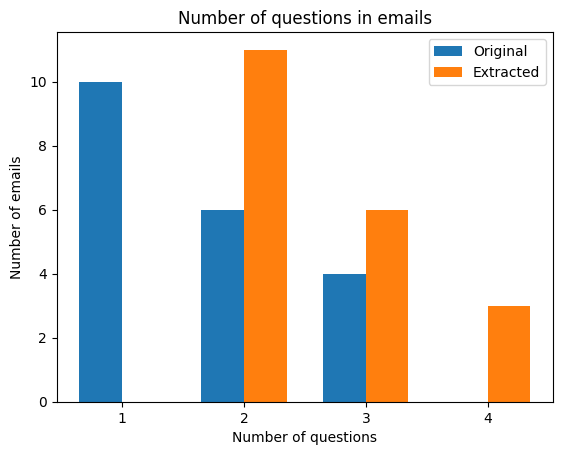

In [13]:
numbers_extracted = {
  'original': {
    '1' : 0,
    '2' : 0,
    '3' : 0,
    '4' : 0
  },
  'extracted': {
    '1' : 0,
    '2' : 0,
    '3' : 0,
    '4' : 0
  }
}

for email in data_extraction["results"]:
    num_original =  len(data_extraction["results"][email]["original_questions"])
    num_extracted = len(data_extraction["results"][email]["extracted_questions"])
    numbers_extracted['original'][str(num_original)] += 1
    numbers_extracted['extracted'][str(num_extracted)] += 1
    
#side by side bar plot
fig, ax = plt.subplots()
bar_width = 0.35
bar_positions = range(4)
bar_positions_extracted = [x + bar_width for x in bar_positions]

ax.bar(bar_positions, numbers_extracted['original'].values(), bar_width, label='Original')
ax.bar(bar_positions_extracted, numbers_extracted['extracted'].values(), bar_width, label='Extracted')

ax.set_xlabel('Number of questions')
ax.set_ylabel('Number of emails')
ax.set_title('Number of questions in emails')
ax.set_xticks([x + bar_width/2 for x in bar_positions])
ax.set_xticklabels(numbers_extracted['original'].keys())
ax.legend()

plt.show()


## Similarity scores

When the value is close to 0, the two texts are very different. When the value is close to 1, the two texts are very similar.

### All together

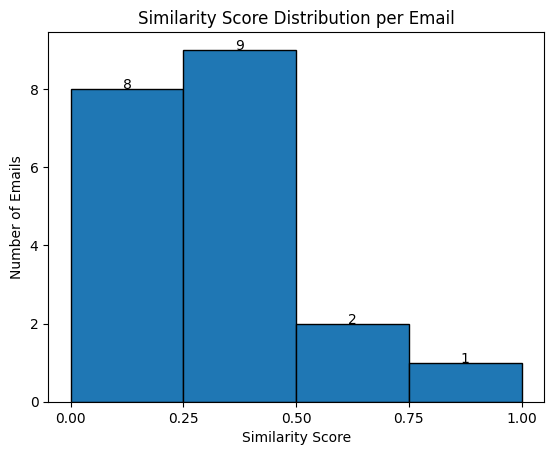

In [6]:
together_similarity_score = {}

for email in data_extraction["results"]:
    all_originals =  "\n ".join([question['question'] for question in data_extraction["results"][email]["original_questions"]])
    all_extracted = "\n ".join([question['question'] for question in data_extraction["results"][email]["extracted_questions"]])
    
    similarity_score = compare(all_originals, all_extracted)
    together_similarity_score[email] = similarity_score    

together_similarity_score
avg_similarity = sum(together_similarity_score.values()) / len(together_similarity_score)

bins = [0, 0.25, 0.5, 0.75, 1]
counts, _, _ = plt.hist(
    together_similarity_score.values(),
    bins=bins,
    edgecolor='black',
)
plt.title("Similarity Score Distribution per Email")
plt.xlabel("Similarity Score")
plt.ylabel("Number of Emails")
plt.xticks(bins)

# Add number on top of each bar
for i, v in enumerate(counts):
    plt.text(bins[i] + 0.125, v, f"{int(v)}", ha='center')

plt.show()
    

### Per question 
*Taking the highest similarity score for each question*

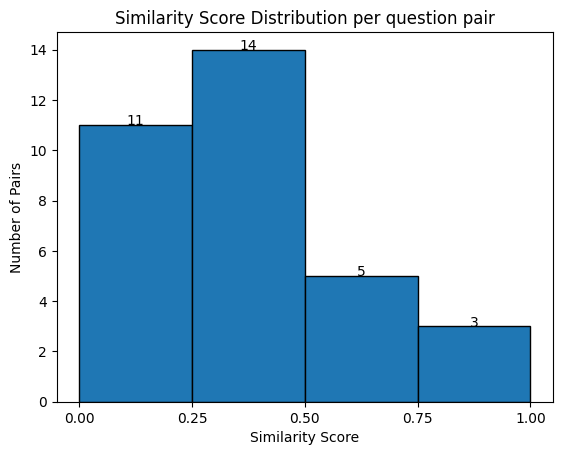

In [16]:
all_pairs = {}
for email in data_extraction["results"]:
    original_questions = [question['question'] for question in data_extraction["results"][email]["original_questions"]]
    extracted_questions = [question['question'] for question in data_extraction["results"][email]["extracted_questions"]]
    best_score = 0
    pairs = []
    for original_question in original_questions:
        for extracted_question in extracted_questions:
            score = compare(original_question, extracted_question)
            if score > best_score:
                best_score = score
                pairs.append({
                    "original": original_question,
                    "extracted": extracted_question,
                    "score": score
                })
                
    all_pairs[email] = pairs
    

bins = [0, 0.25, 0.5, 0.75, 1]

counts, _, _ = plt.hist(
    [pair["score"] for pairs in all_pairs.values() for pair in pairs],
    bins=bins,
    edgecolor='black',
)

plt.title("Similarity Score Distribution per question pair")
plt.xlabel("Similarity Score")
plt.ylabel("Number of Pairs")
plt.xticks(bins)

for i, v in enumerate(counts):
    plt.text(bins[i] + 0.125, v, f"{int(v)}", ha='center')
    
plt.show()
  

# Time

Average time per question: 17.49 seconds
Average time per email: 15.66 seconds


/var/folders/cg/bpchphfn45l7z59lyhbgtm080000gn/T/ipykernel_14476/1288245855.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


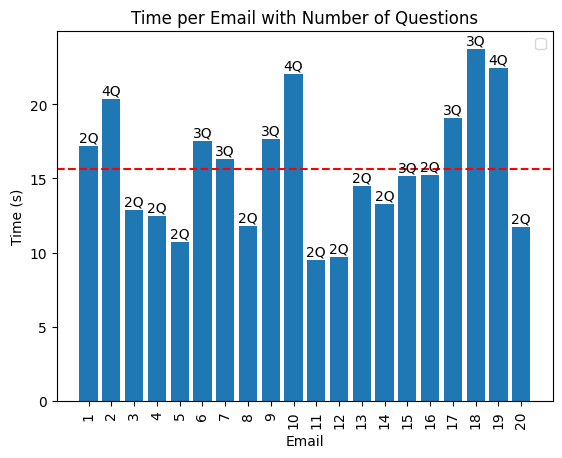

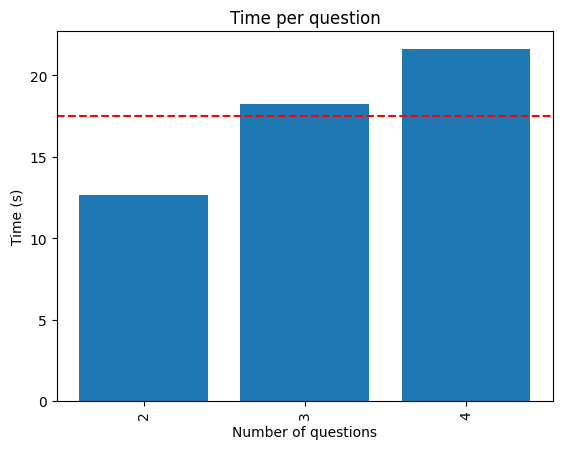

In [22]:
time_per_question = {}
quantity_per_question = {}
time_per_email = {}

for i, email in enumerate(data_extraction["results"]):
    time = data_extraction["results"][email]["extraction_time"]
    num_questions = len(data_extraction["results"][email]["extracted_questions"])
    time_per_question[num_questions] = time_per_question.get(num_questions, 0) + time
    quantity_per_question[num_questions] = quantity_per_question.get(num_questions, 0) + 1
    time_per_email[i+1] = time
        
time_per_question = {k: v / quantity_per_question[k] for k, v in time_per_question.items()}

avg_time_per_question = sum(time_per_question.values()) / len(time_per_question)
avg_time_per_email = sum(time_per_email.values()) / len(time_per_email)

print(f"Average time per question: {avg_time_per_question:.2f} seconds")
print(f"Average time per email: {avg_time_per_email:.2f} seconds")



plt.bar(time_per_email.keys(), time_per_email.values())
plt.axhline(y=avg_time_per_email, color='r', linestyle='--')

# put on the bar plot the number of question extracted
for i, email in enumerate(data_extraction["results"]):
    num_questions = len(data_extraction["results"][email]["extracted_questions"])
    plt.text(
        i + 1,  # X coordinate for the text
        time_per_email[i + 1] + 0.1,  # Y coordinate, slightly above the bar
        f"{num_questions}Q",  # Text to display
        ha='center',  # Horizontal alignment
        va='bottom',  # Vertical alignment
        fontsize=10,  # Font size
        color='black'  # Font color
    )

plt.title("Time per Email with Number of Questions")
plt.ylabel("Time (s)")
plt.xlabel("Email")
plt.xticks(list(time_per_email.keys()), list(time_per_email.keys()), rotation=90)
plt.legend()
plt.show()


plt.bar(time_per_question.keys(), time_per_question.values())
plt.axhline(y=avg_time_per_question, color='r', linestyle='--')
plt.title("Time per question")
plt.ylabel("Time (s)")
plt.xlabel("Number of questions")
plt.xticks(list(time_per_question.keys()), list(time_per_question.keys()), rotation=90)
plt.show()
